**Install packages**

In [ ]:
!pip install bertopic
!pip install joblib==1.1.0
!pip install spacy_langdetect
!pip install lexicalrichness
!pip install sentence-transformers
!pip install torch

**Import packages**

In [ ]:
import numpy as np
from bertopic import BERTopic
import pandas as pd
import torch
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer

**Load cleaned data (SSRI_SNRI_all from cleaning script)**

In [3]:
def LoadData(path):
    data_df = pd.read_csv(path)
    data_list = data_df["review"].to_list()
    return data_df, data_list

data_df, data_list = LoadData(r'/PATH/SSRI_SNRI_all.csv')

****Initialize model and dependencies****

In [4]:
#Initialize sentence transformer embedding model
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

#Initialize topic representation model
ctfidf_model = ClassTfidfTransformer()

#Initialize UMAP
umap_model = UMAP(
                n_neighbors = 10, #the number of neighboring sample points used when making the manifold approximation. Larger values = more global view (larger clusters), smaller values = more local view. 
                n_components = 5, #best to keep to default of 5
                min_dist = 0.0,
                metric = 'cosine',
                random_state=15)

#Initialize HBDScan
hdbscan_model = HDBSCAN(
                    min_cluster_size = 5, #specifies minimum size of a cluster = how many clusters are generated. Default = 10. Increasing = less clusters of larger size. Usually not advised to decrease.
                    metric = 'euclidean', #keep this when n_components are default value
                    min_samples = 5, #usually = min_cluster_size. Specifies the amount of outliers generated. Lower than min_cluster_size = reduce the amount of noise.
                    cluster_selection_method = 'eom', 
                    prediction_data = True)

**Run model**

In [5]:
model = BERTopic(
                embedding_model = sentence_model,
                umap_model = umap_model,
                hdbscan_model = hdbscan_model,
                ctfidf_model = ctfidf_model,
                calculate_probabilities = True, #calculate the probabilities of each topic to each document
                top_n_words = 10, #the number of words per topic to be extracted. Advice: Keep this value below 30 and preferably between 10 and 20.
                #diversity = 0.2, #limit the number of duplicate words we find in each topic. 0 = not at all diverse, 1 = completely diverse
                min_topic_size = 10, #specifies what the minimum size a topic can be. Lower value = more topics created. Too low can lead to many micro clusters. Default of 10.
                nr_topics = 15 #specifies after training the number of topics that will be reduced to. Use "auto" to automatically reduce topics using HDBSCAN.
                )

topics, probs = model.fit_transform(data_list)

#Apply vectorizer
vectorizer_model = CountVectorizer(stop_words = "english",
                                    ngram_range = (1, 2), #Used when creating the topic representation. The number of words you want in your topic representation. To e.g. represent "New York" as one topic, n-gram range should be (1, 2)
                                    min_df = 5) #ignore terms that have a document frequency lower than the given threshold
                                    #max_df = 300) #ignore terms that have a document frequency higher than the given threshold. #300 worked well, testing lower

#Update model
model.update_topics(data_list, vectorizer_model = vectorizer_model)

#Save model
model.save("/Users/evasahlholdt/Desktop/MA/NLP/Exam/Code/NLP_exam/topic_models/BERTopic")

#Set custom labels
topic_labels = model.generate_topic_labels(nr_words = 2, topic_prefix = True, word_length = 10, separator = ", ")
model.set_topic_labels(topic_labels)

**Save dataframe with reviews according to topics for sentiment analysis**

In [7]:
topic_df = pd.DataFrame({'topic': topics, 'document': data_list})
topic_df.rename(columns={'document':'review'}, inplace=True)
topic_reviews = data_df.merge(topic_df, on = 'review')
topic_reviews.to_csv(r'/Users/evasahlholdt/Desktop/MA/NLP/Exam/Code/NLP_exam/datasets/topic_reviews_df.csv', index = False, header = True)

**Extract class-wise topics**

In [9]:
#Create topic tables

def TopicTable(model, data_df, data_list, topic_labels, column):
    classes = data_df[column].to_list() #check
    topic_table = model.topics_per_class(data_list, classes = classes)
    label_len = len(topic_labels)
    table_len = len(topic_table)
    topic_table["Label"] = topic_labels * int(table_len/label_len)
    return topic_table

topic_table_drug = TopicTable(model, data_df, data_list, topic_labels, "drugName")
topic_table_sent = TopicTable(model, data_df, data_list, topic_labels, "rating_class")

**Calculate relative frequencies**

In [21]:
#How many reviews in each drug class?
n_SSRI = len(data_df[data_df["drugName"] == "SSRI"])
n_SNRI = len(data_df[data_df["drugName"] == "SNRI"])

#Copy table to avoid overwriting
topic_table_drug_copy = topic_table_drug.copy()

#loop through dataframe to calculate respective new values
for index, row in topic_table_drug_copy.iterrows():
  if row['Class'] == 'SSRI':
    topic_table_drug_copy.loc[index,'Frequency'] = row['Frequency'] / n_SSRI * 100
  elif row['Class'] == 'SNRI':
    topic_table_drug_copy.loc[index,'Frequency'] = row['Frequency'] / n_SNRI * 100

#Add the relative freq column to original dataframe
rel_freq = topic_table_drug_copy["Frequency"].to_list()
topic_table_drug["Relative Frequency"] = rel_freq

#Same procedure
n_SSRI_pos = len(data_df[data_df["rating_class"] == "positive_SSRI"])
n_SSRI_neg = len(data_df[data_df["rating_class"] == "negative_SSRI"])
n_SNRI_pos = len(data_df[data_df["rating_class"] == "positive_SNRI"])
n_SNRI_neg = len(data_df[data_df["rating_class"] == "negative_SNRI"])

#Copy table to avoid overwriting
topic_table_sent_copy = topic_table_sent.copy()

#loop through dataframe to calculate respective new values
for index, row in topic_table_sent_copy.iterrows():
  if row['Class'] == 'negative_SSRI':
    topic_table_sent_copy.loc[index,'Frequency'] = row['Frequency'] / n_SSRI_neg * 100
  elif row['Class'] == 'positive_SSRI':
    topic_table_sent_copy.loc[index,'Frequency'] = row['Frequency'] / n_SSRI_pos * 100
  elif row['Class'] == 'negative_SNRI':
    topic_table_sent_copy.loc[index,'Frequency'] = row['Frequency'] / n_SNRI_pos * 100
  elif row['Class'] == 'positive_SNRI':
    topic_table_sent_copy.loc[index,'Frequency'] = row['Frequency'] / n_SNRI_pos * 100

#Add the relative freq column to original dataframe
rel_freq = topic_table_sent_copy["Frequency"].to_list()
topic_table_sent["Relative Frequency"] = rel_freq


**Visualizations**

**Hierchical clustering and top words**

In [28]:
#Hierarchical clustering 
model.visualize_hierarchy(custom_labels = True)

#Word scores
model.visualize_barchart(top_n_topics = 16, n_words=9, custom_labels=True, title= "Top Words Per Topic")

**Customized plots**

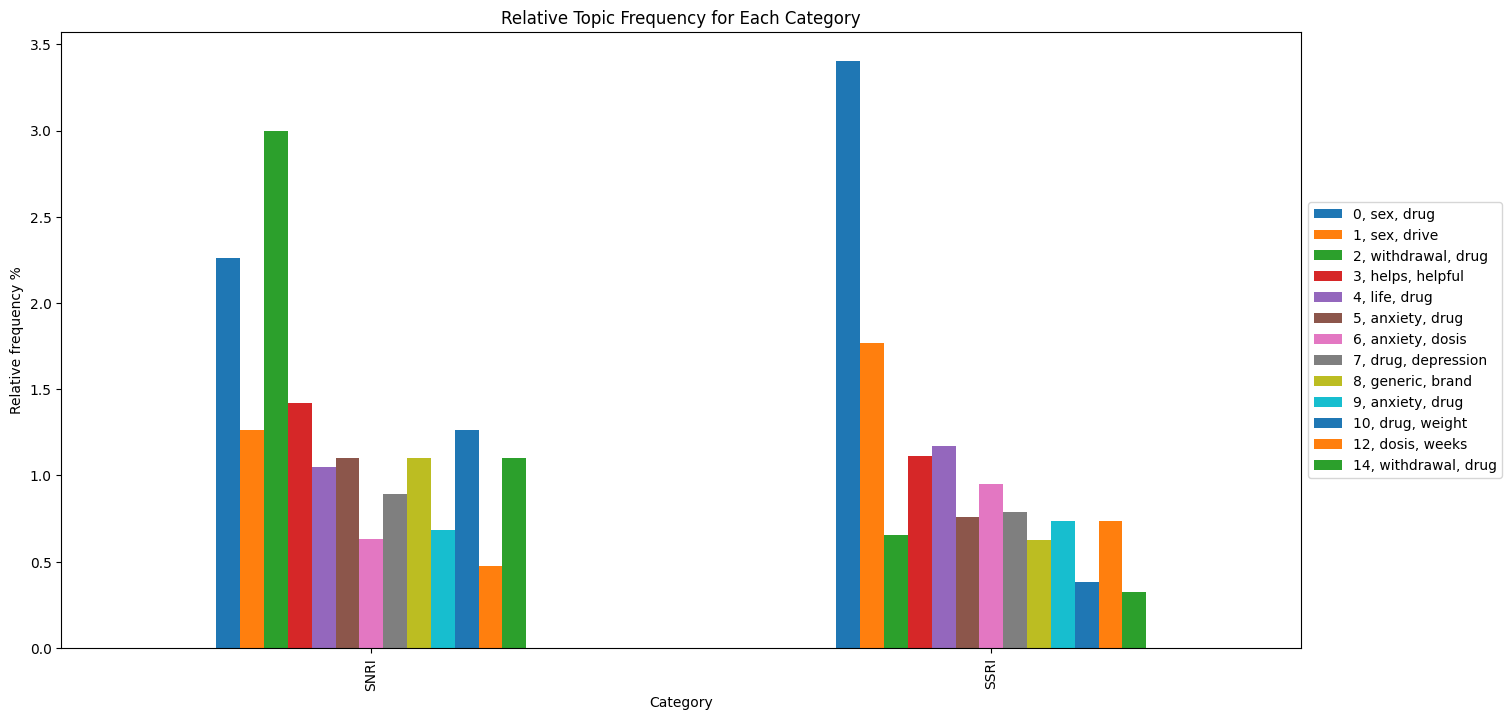

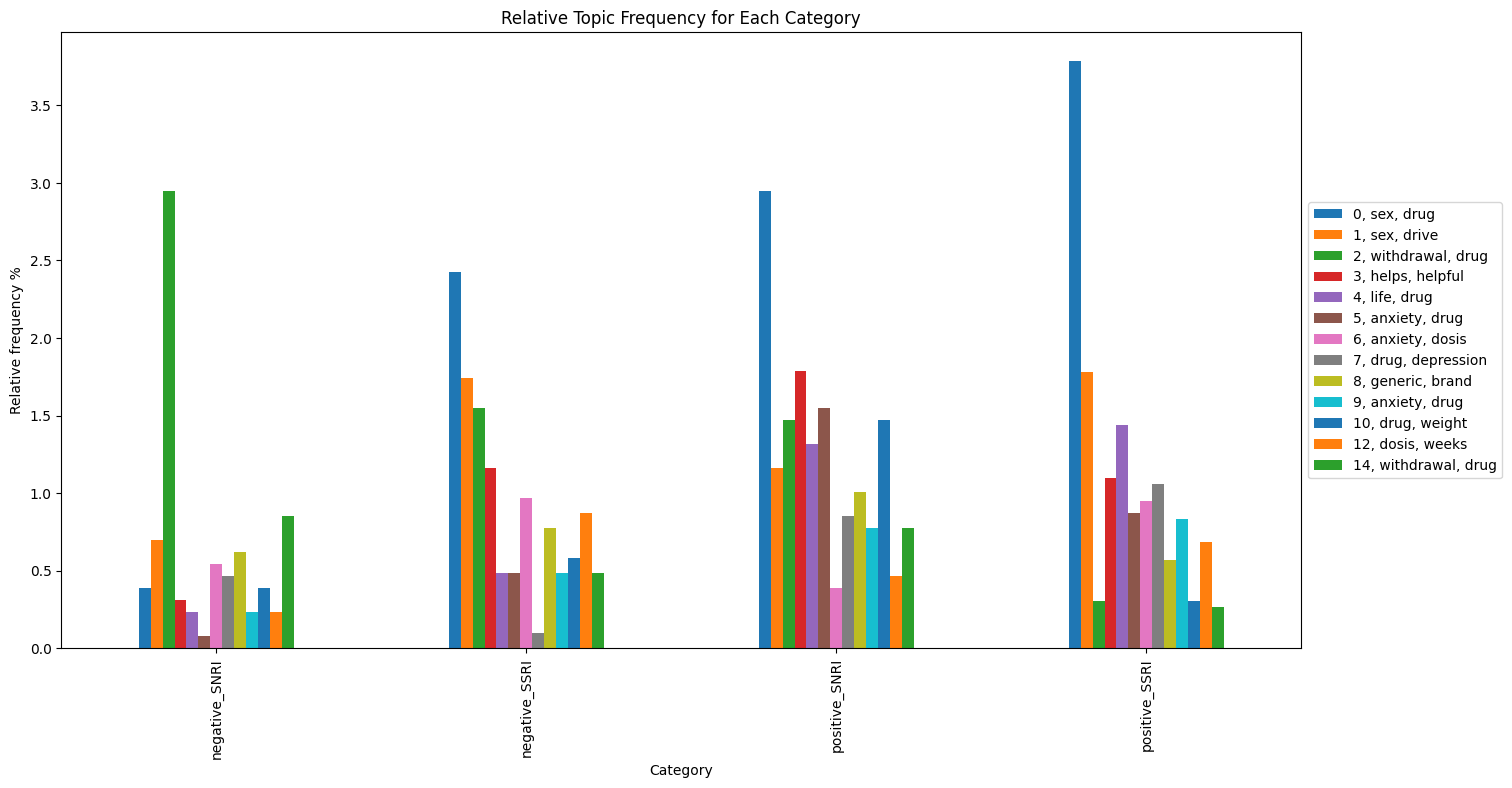

In [38]:
def PivotTable(topic_table):
	to_drop = (-1, 11, 13)
	subset = topic_table.drop(topic_table[topic_table['Topic'].isin(to_drop)].index)
	df_pivot = pd.pivot_table(
		subset,
		values="Relative Frequency",
		index="Class",
		columns="Label",
		aggfunc=np.mean)
	sorted_columns = sorted(df_pivot.columns, key=lambda x: int(x.split(',')[0]))
	df_pivot = df_pivot.reindex(columns=sorted_columns)
	return df_pivot

df_pivot_drug = PivotTable(topic_table_drug)
df_pivot_sent = PivotTable(topic_table_sent)

#Bar chart 

def PlotBar(table_pivot):
	ax = table_pivot.plot(kind="bar")
	fig = ax.get_figure()
	fig.set_size_inches(16, 8)
	ax.set_xlabel("Category")
	ax.set_ylabel("Relative frequency %")
	ax.set_title("Relative Topic Frequency for Each Category")
	ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
	fig.show()

#Bar chart for SSRI / SNRI categories
PlotBar(df_pivot_drug)

#Bar chart for SSRI pos/neg and SNRI pos/neg categories
PlotBar(df_pivot_sent)
